In [1]:
import numpy as np
import os
import pyedflib
import tensorflow as tf

# EEGNet specific imports
import sys
sys.path.append('/home/kaleb/Documents/GitHub/BrainControlledWheelchair/')
# from EEG_ML.EEGModels import EEGNet, EEGNet_wo_softmax
import EEG_ML.EEGModels as eegmodels
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import read_edf_files
import innvestigate

from fuckingshit import EEGNet_wo_softmax

import matplotlib.pyplot as plt 


2023-09-24 20:45:44.580040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 20:45:44.988237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-24 20:45:44.988274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-24 20:45:45.050406: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-24 20:45:46.768328: W tensorflow/stream_executor/platform/de

In [2]:
kernels, chans = 1, 64
label_mapping = {
        1: "Rest",
        2: "Squeeze Both Fists",
        3: "Squeeze Both Feet",
        4: "Squeeze Left Hand",
        5: "Squeeze Right Hand",
    }
num_labels = 5
X, Y = read_edf_files.reader() # use other function to read the edf files

X.shape:  (180, 64, 656)
Y.shape:  (180,)


In [3]:
################################################################
## Process, filter, and epoch the data
# init arrays to train/validate/test. Make split 50/25/25
half = int(len(X) / 2)
quarter = int(half / 2)
three_fourths = half + quarter

X_train = X[:half, :, :]
X_validate = X[half : three_fourths, :, :]
X_test = X[three_fourths:, :, :]

y_train = Y[:half]
y_validate = Y[half:three_fourths]
y_test = Y[three_fourths:]
print('x_train shape: ', X_train.shape, '\ny_train shape: ', y_train.shape)

x_train shape:  (90, 64, 656) 
y_train shape:  (90,)


In [4]:
model = EEGNet_wo_softmax(nb_classes=num_labels, Chans=X_train.shape[1], Samples=X_train.shape[2],
               dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16,
                 dropoutType= 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

2023-09-24 20:45:59.656442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-24 20:45:59.656493: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-24 20:45:59.656522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kaleb-School): /proc/driver/nvidia/version does not exist
2023-09-24 20:45:59.656911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Convert EEG data to a TensorFlow tensor
X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)

# Create an analyzer for gradient analysis
analyzer = innvestigate.create_analyzer('gradient', model, reverse_verbose=True)

# Initialize an array to store class-specific gradient maps
class_gradients = []

# Iterate through each unique class label
unique_labels = np.unique(Y)
for label in unique_labels:
    # Select trials belonging to the current class
    class_indices = np.where(Y == label)[0]
    # class_data = X_tensor[class_indices]
    class_data = tf.gather(X_tensor, class_indices)

    # Create a GradientTape context
    with tf.GradientTape() as tape:
        tape.watch(class_data)
        class_prediction = model(class_data)

    # Compute the gradients for the current class
    class_gradients.append(tape.gradient(class_prediction, class_data))

# Convert the list of class-specific gradient arrays to a numpy array
class_gradients = np.array(class_gradients)

# Aggregate the gradients (e.g., by averaging or summing across trials)
# You can choose the aggregation method based on your analysis goals

# Normalize the aggregated gradient maps to [0, 1]
min_val = np.min(class_gradients)
max_val = np.max(class_gradients)
normalized_gradients = (class_gradients - min_val) / (max_val - min_val)

# Visualize the normalized gradient maps for each class
for i, label in enumerate(unique_labels):
    plt.figure()
    plt.imshow(normalized_gradients[i, 0], cmap='viridis', aspect='auto')
    plt.title(f'Class {label} - Channel Importance')
    plt.colorbar()
    plt.show()

/tmp/ipykernel_100897/1220963812.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  class_gradients = np.array(class_gradients)


InvalidArgumentError: {{function_node __wrapped__LessEqual_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [90,64,656] vs. [23,64,656] [Op:LessEqual]

In [67]:
# chat gpt 
# convert to tensor
X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
with tf.GradientTape() as tape: 
    tape.watch(X_tensor)
    prediction = model(X_tensor)

gradients = tape.gradient(prediction, X_tensor)

2023-09-24 19:43:42.747933: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 241827840 exceeds 10% of free system memory.
2023-09-24 19:43:43.190060: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 241827840 exceeds 10% of free system memory.
2023-09-24 19:43:43.692105: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 241827840 exceeds 10% of free system memory.
2023-09-24 19:43:44.420477: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 241827840 exceeds 10% of free system memory.


(180, 64, 656)


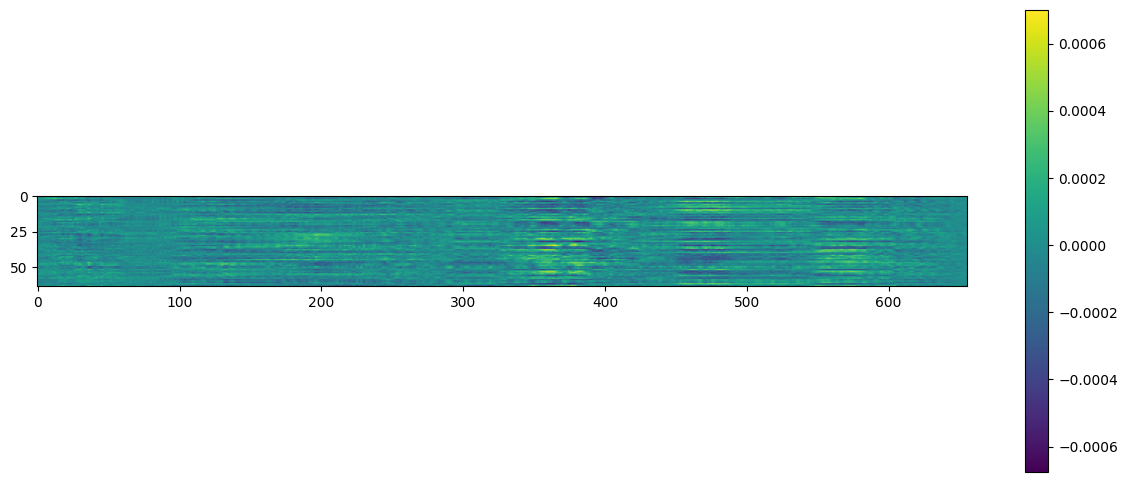

In [73]:
print(gradients.shape)
plt.figure(figsize=(15,6))

plt.imshow(gradients[170], cmap='viridis') # , interpolation='nearest')
plt.colorbar()

plt.show()

In [68]:
analyzer = innvestigate.create_analyzer('gradient', model, reverse_verbose=True)
analysis = analyzer.analyze(X_tensor)

print(analysis[0].shape)
# channel_relevance = np.sum(analysis, axis=(1,2))

# # select the top 16 channels with the highest relevance
# top_channels_indices = np.argsort(channel_relevance)[-16:]
plt.figure(figsize=(15,6))

plt.imshow(analysis[10], cmap='viridis') # , interpolation='nearest')
plt.colorbar()

plt.show()

Reverse model: <keras.engine.functional.Functional object at 0x7f0d29a42200>
[NID: 15] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7f0d29ba6050>


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

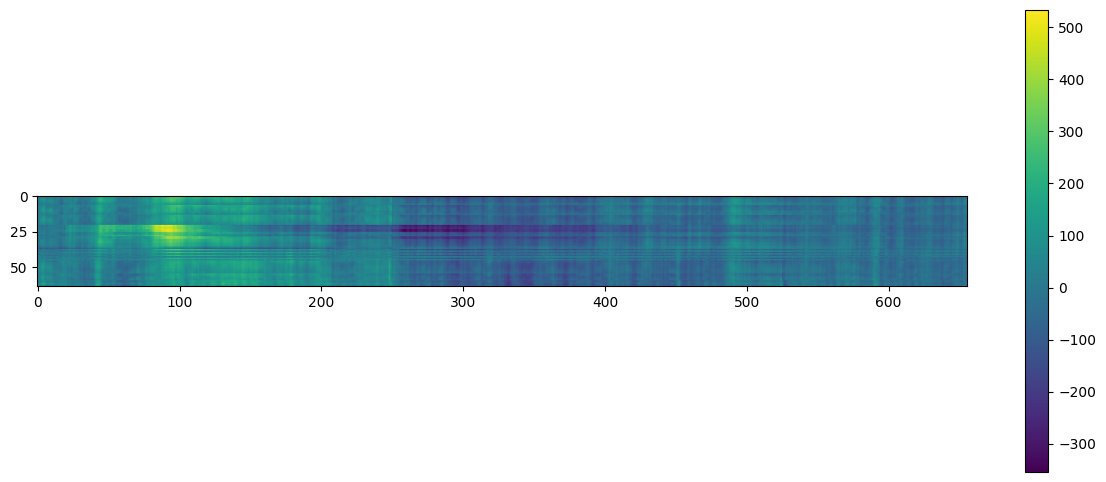

In [33]:
plt.figure(figsize=(15,6))

plt.imshow(X[10], cmap='viridis') # , interpolation='nearest')
plt.colorbar()

plt.show()